In [ ]:

import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from google.colab import drive
from PIL import Image
import os

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, species_to_label, danger_levels):
        self.img_dir = img_dir
        self.species_to_label = species_to_label
        self.danger_levels = danger_levels
        self.img_files = []
        self.labels = []
        self.danger_labels = []
        VALID_EXTENSIONS = {".jpg", ".jpeg", ".png"}

        for species in os.listdir(img_dir):
            species_dir = os.path.join(img_dir, species)
            if os.path.isdir(species_dir) and species in species_to_label:
                images = [f for f in os.listdir(species_dir) if os.path.splitext(f)[1].lower() in VALID_EXTENSIONS]
                for img_name in images:
                    img_path = os.path.join(species_dir, img_name)
                    self.img_files.append(img_path)
                    self.labels.append(species_to_label[species])
                    self.danger_labels.append(danger_levels[species])

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        species_label = self.labels[idx]
        danger_label = self.danger_labels[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None
        image_tensor = self.transform(image)
        return image_tensor, torch.tensor(species_label, dtype=torch.long), torch.tensor(danger_label, dtype=torch.long)

species_to_label = {
    "bear": 0, "bison": 1, "boar": 2, "cow": 3, "deer": 4, "donkey": 5, "elephant": 6,
    "fox": 7, "goat": 8, "hippopotamus": 9, "horse": 10, "hyena": 11, "leopard": 12,
    "lion": 13, "ox": 14, "pig": 15, "porcupine": 16, "rhinoceros": 17, "tiger": 18
}
danger_levels = {
    "bear": 2, "bison": 1, "boar": 2, "cow": 0, "deer": 0, "donkey": 0, "elephant": 1,
    "fox": 2, "goat": 0, "hippopotamus": 1, "horse": 0, "hyena": 2, "leopard": 2,
    "lion": 2, "ox": 1, "pig": 0, "porcupine": 0, "rhinoceros": 1, "tiger": 2
}

In [ ]:
class CNNTransformer(nn.Module):
    def __init__(self, num_species_classes, num_danger_levels):
        super(CNNTransformer, self).__init__()
        self.cnn = resnet18(pretrained=False)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 512)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=512, nhead=8, dim_feedforward=2048, dropout=0.1),
            num_layers=3
        )
        self.fc_species = nn.Linear(512, num_species_classes)
        self.fc_danger = nn.Linear(512, num_danger_levels)

    def forward(self, x):
        B = x.size(0)
        x = self.cnn(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        species_out = self.fc_species(x)
        danger_out = self.fc_danger(x)
        return species_out, danger_out

In [ ]:
species_classes = ['bear', 'bison', 'boar', 'cow', 'deer', 'donkey', 'elephant', 'fox', 'goat',
                  'hippopotamus', 'horse', 'hyena', 'leopard', 'lion', 'ox', 'pig', 'porcupine',
                  'rhinoceros', 'tiger']
danger_names = ["Low", "Medium", "High"]
num_species_classes = len(species_classes)  # 19
num_danger_levels = len(danger_names)      # 3

In [ ]:
model_path = "/content/drive/MyDrive/cnn_transformer_20250402_103611.pth"
model = CNNTransformer(num_species_classes=num_species_classes, num_danger_levels=num_danger_levels)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()






/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


CNNTransformer(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch

def predict_image(image_path, model, device, species_classes, danger_names):

    high_danger = ['tiger', 'bear', 'lion', 'hyena', 'leopard']
    medium_danger = ['boar', 'elephant', 'hippopotamus', 'rhinoceros']
    low_danger = ['bison', 'cow', 'deer', 'donkey', 'fox', 'goat', 'horse', 'ox', 'pig', 'porcupine']

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None, None

    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        species_out, danger_out = model(image_tensor)
        _, species_pred = torch.max(species_out, 1)
        _, danger_pred = torch.max(danger_out, 1)

    predicted_species = species_classes[species_pred.item()]
    predicted_danger = danger_names[danger_pred.item()]


    category = "Unknown"
    expected_danger = None
    if predicted_species.lower() in high_danger:
        category = "High Danger"
        expected_danger = "High"
    elif predicted_species.lower() in medium_danger:
        category = "Medium Danger"
        expected_danger = "Medium"
    elif predicted_species.lower() in low_danger:
        category = "Low Danger"
        expected_danger = "Low"


    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_species}, {category}", fontsize=12)
    plt.axis('off')
    plt.show()


    print(f"Predicted Species: {predicted_species}")
    print(f"Category: {category}")
    print(f"Expected Danger Level: {expected_danger}")


    return predicted_species, predicted_danger

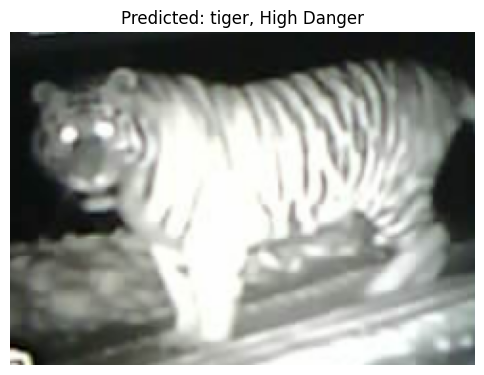

Predicted Species: tiger
Category: High Danger
Expected Danger Level: High


In [ ]:

test_image_path = "/content/drive/MyDrive/cat.png"
species_pred, danger_pred = predict_image(test_image_path, model, device, species_classes, danger_names)


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


val_dir = "/content/drive/MyDrive/animals/val"
val_dataset = CustomDataset(val_dir, species_to_label, danger_levels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


def evaluate_model(model, val_loader, device):
    model.eval()
    species_true, species_pred, danger_true, danger_pred = [], [], [], []
    species_probs, danger_probs = [], []

    with torch.no_grad():
        for images, species_labels, danger_labels in val_loader:
            if images is None:
                continue
            images = images.to(device)
            species_labels = species_labels.to(device)
            danger_labels = danger_labels.to(device)

            species_out, danger_out = model(images)
            species_probs_batch = torch.softmax(species_out, dim=1)
            danger_probs_batch = torch.softmax(danger_out, dim=1)
            _, species_pred_batch = torch.max(species_out, 1)
            _, danger_pred_batch = torch.max(danger_out, 1)

            species_true.extend(species_labels.cpu().numpy())
            species_pred.extend(species_pred_batch.cpu().numpy())
            danger_true.extend(danger_labels.cpu().numpy())
            danger_pred.extend(danger_pred_batch.cpu().numpy())
            species_probs.extend(species_probs_batch.cpu().numpy())
            danger_probs.extend(danger_probs_batch.cpu().numpy())

    return (np.array(species_true), np.array(species_pred), np.array(species_probs),
            np.array(danger_true), np.array(danger_pred), np.array(danger_probs))


species_true, species_pred, species_probs, danger_true, danger_pred, danger_probs = evaluate_model(model, val_loader, device)

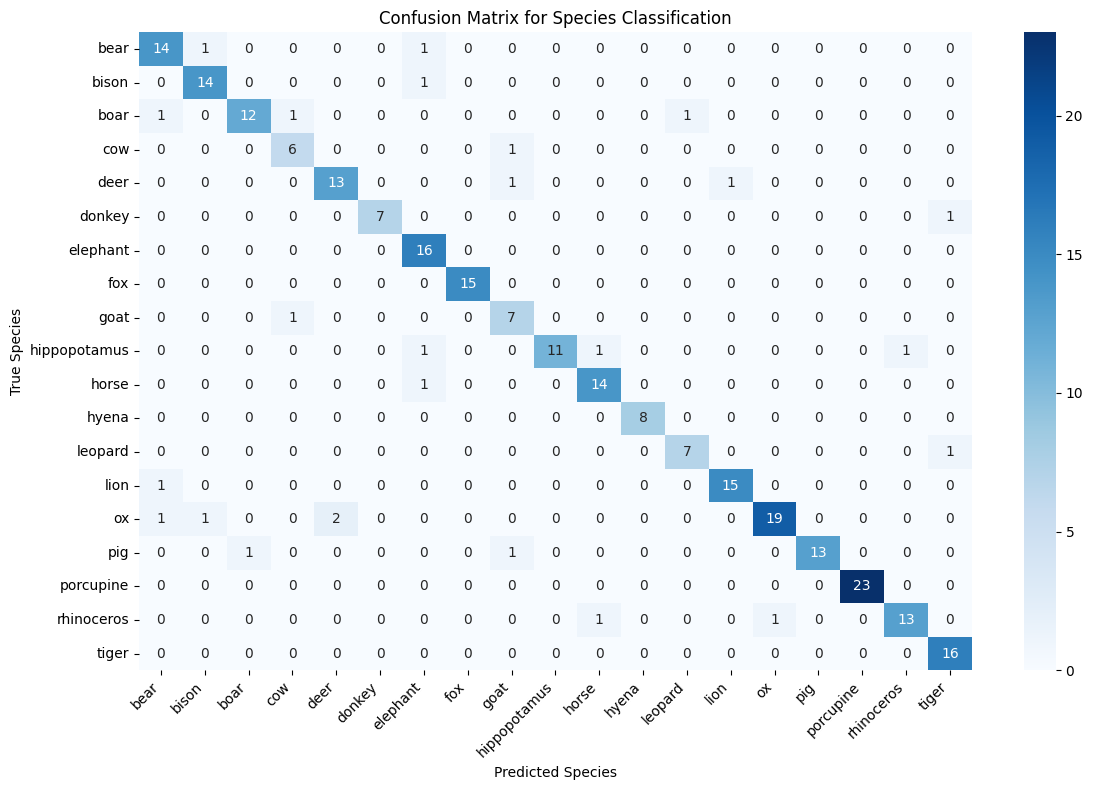

In [ ]:
# Confusion matrix for species
cm_species = confusion_matrix(species_true, species_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_species, annot=True, fmt="d", cmap="Blues", xticklabels=species_classes, yticklabels=species_classes)
plt.xlabel("Predicted Species")
plt.ylabel("True Species")
plt.title("Confusion Matrix for Species Classification")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix_species.png', dpi=300)
plt.show()

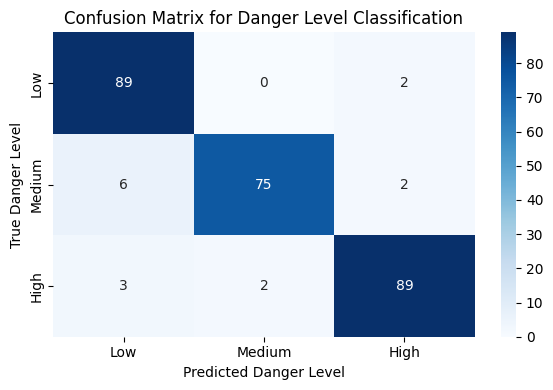

In [ ]:
# Confusion matrix for danger levels
cm_danger = confusion_matrix(danger_true, danger_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_danger, annot=True, fmt="d", cmap="Blues", xticklabels=danger_names, yticklabels=danger_names)
plt.xlabel("Predicted Danger Level")
plt.ylabel("True Danger Level")
plt.title("Confusion Matrix for Danger Level Classification")
plt.tight_layout()
plt.savefig('confusion_matrix_danger.png', dpi=300)
plt.show()

<Figure size 1500x600 with 0 Axes>

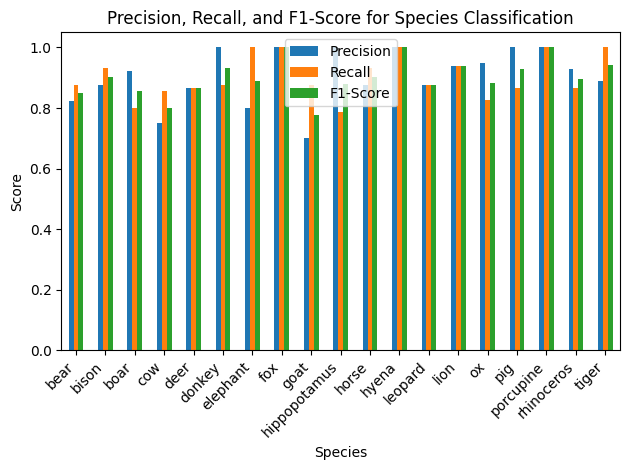

In [ ]:
# Classification report for species
import pandas as pd

report_species = classification_report(species_true, species_pred, target_names=species_classes, output_dict=True)
df_species = pd.DataFrame({
    'Class': species_classes,
    'Precision': [report_species[cls]['precision'] for cls in species_classes],
    'Recall': [report_species[cls]['recall'] for cls in species_classes],
    'F1-Score': [report_species[cls]['f1-score'] for cls in species_classes]
})

# Plot
plt.figure(figsize=(15, 6))
df_species.set_index('Class')[['Precision', 'Recall', 'F1-Score']].plot(kind='bar')
plt.xlabel('Species')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Species Classification')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('metrics_species.png', dpi=300)
plt.show()

<Figure size 800x500 with 0 Axes>

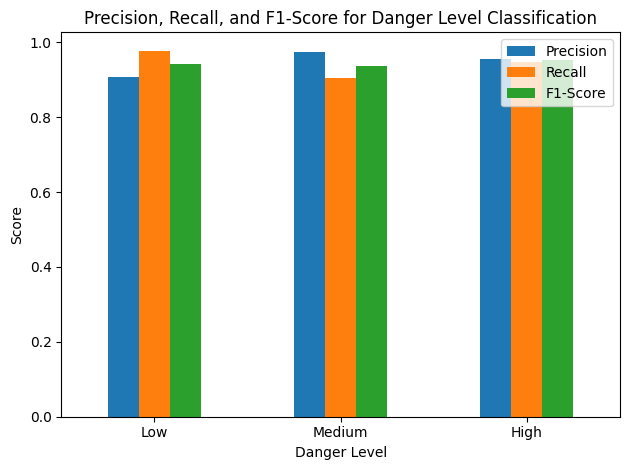

In [ ]:
# Classification report for danger levels
report_danger = classification_report(danger_true, danger_pred, target_names=danger_names, output_dict=True)
df_danger = pd.DataFrame({
    'Class': danger_names,
    'Precision': [report_danger[cls]['precision'] for cls in danger_names],
    'Recall': [report_danger[cls]['recall'] for cls in danger_names],
    'F1-Score': [report_danger[cls]['f1-score'] for cls in danger_names]
})

# Plot
plt.figure(figsize=(8, 5))
df_danger.set_index('Class')[['Precision', 'Recall', 'F1-Score']].plot(kind='bar')
plt.xlabel('Danger Level')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Danger Level Classification')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('metrics_danger.png', dpi=300)
plt.show()

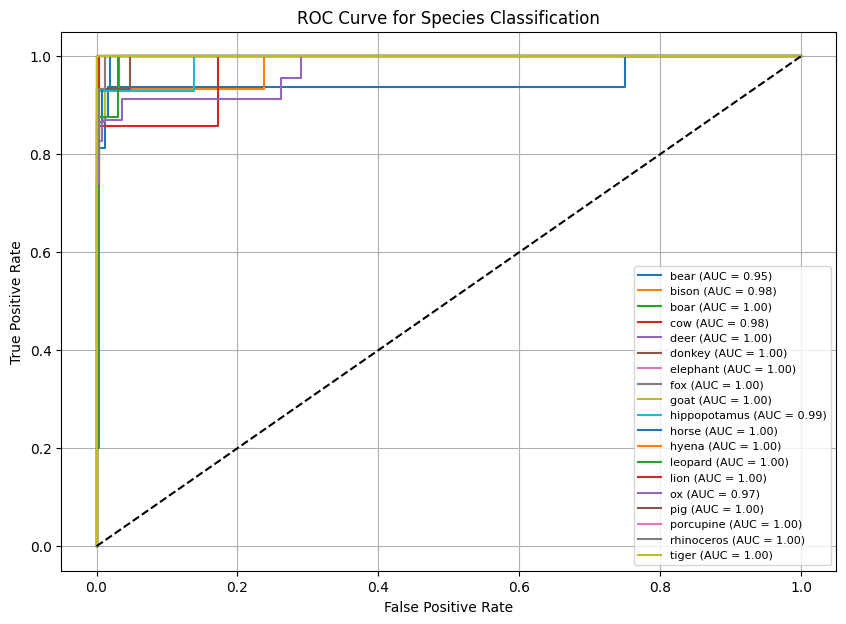

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize species labels
y_true_bin_species = label_binarize(species_true, classes=range(num_species_classes))
plt.figure(figsize=(10, 7))
for i in range(num_species_classes):
    fpr, tpr, _ = roc_curve(y_true_bin_species[:, i], species_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{species_classes[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Species Classification')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.savefig('roc_species.png', dpi=300)
plt.show()

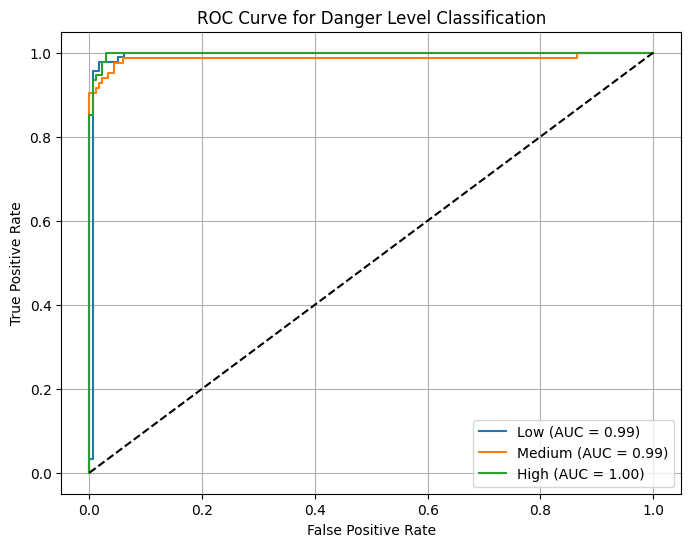

In [ ]:
# Binarize danger labels
y_true_bin_danger = label_binarize(danger_true, classes=range(num_danger_levels))
plt.figure(figsize=(8, 6))
for i in range(num_danger_levels):
    fpr, tpr, _ = roc_curve(y_true_bin_danger[:, i], danger_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{danger_names[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Danger Level Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_danger.png', dpi=300)
plt.show()

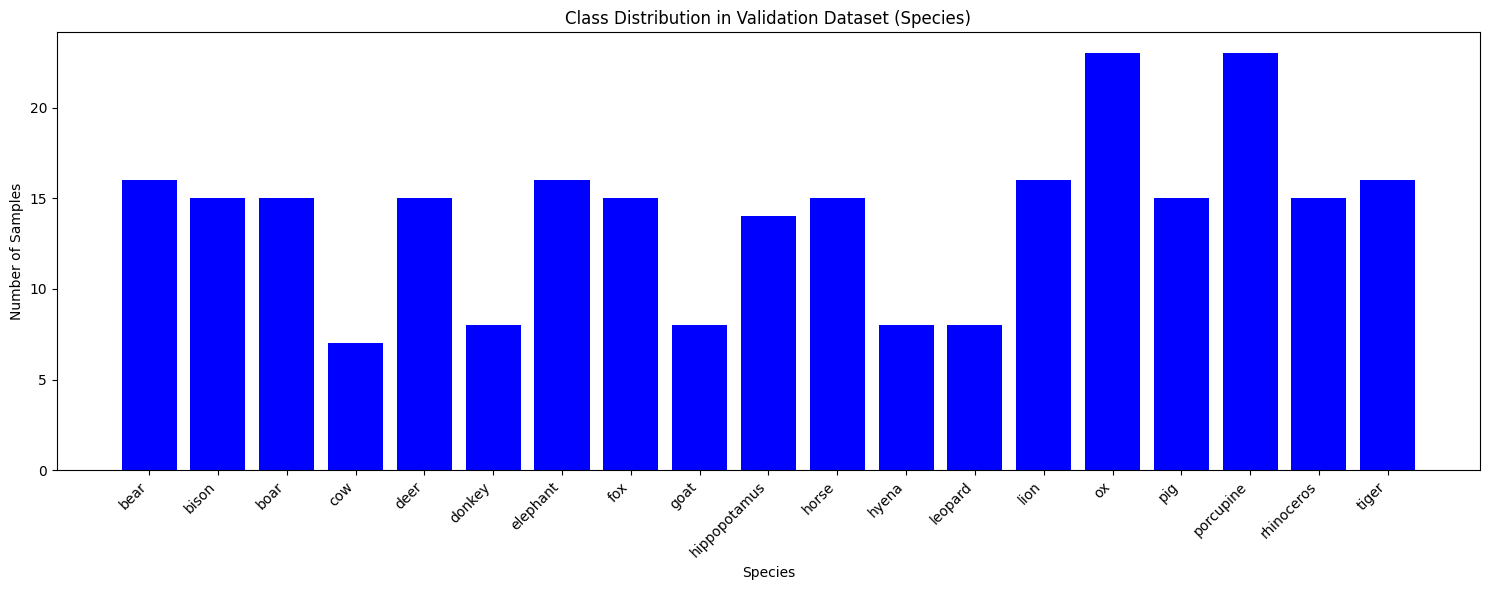

In [ ]:
from collections import Counter

# Count samples per species
species_counts = Counter(val_dataset.labels)
species_freq = [species_counts[i] for i in range(num_species_classes)]

# Plot
plt.figure(figsize=(15, 6))
plt.bar(range(num_species_classes), species_freq, color='blue')
plt.xlabel('Species')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Validation Dataset (Species)')
plt.xticks(range(num_species_classes), species_classes, rotation=45, ha='right')
plt.tight_layout()
plt.savefig('distribution_species.png', dpi=300)
plt.show()

In [ ]:
train_path = "/content/drive/MyDrive/animals/train"
val_path = "/content/drive/MyDrive/animals/val"